In [1]:
#import the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

In [2]:
cdatasub = pd.read_csv("./london_flows.csv")
cdatasub.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [3]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(np.sqrt(res.mean()), 3)
    
    return RMSE

In [4]:
# Formula for doubly-constrained model
doubly_constrained_formula = 'flows ~ station_origin + station_destination + distance - 1'

# Doubly Constrained Model with smf
sim = smf.glm(formula=doubly_constrained_formula, data=cdatasub, family=sm.families.Poisson()).fit()

#print(sim.summary())


In [5]:
#Generate Predictions and add to flows dataframe
cdatasub["doubsimfitted"] = np.round(sim.mu)

#Summary Statistics
print("RSquared =")
print(CalcRSqaured(cdatasub["flows"], cdatasub["doubsimfitted"]))
print("RMSE =")
print(CalcRMSE(cdatasub["flows"], cdatasub["doubsimfitted"]))

RSquared =
0.47662577391035543
RMSE =
95.214


In [6]:
cdatasub['log_dest_jobs'] = np.log(cdatasub['jobs'] + .001)

# Formula for doubly-constrained model
doubly_constrained_formula = 'flows ~ station_origin + log_dest_jobs + distance-1'

# Doubly Constrained Model with smf
doubSim = smf.glm(formula=doubly_constrained_formula, data=cdatasub, family=sm.families.Poisson()).fit()

#print(sim.summary())

#Generate Predictions and add to flows dataframe
cdatasub["doubsimfitted"] = np.round(doubSim.mu)

#Summary Statistics
print("RSquared =")
print(CalcRSqaured(cdatasub["flows"], cdatasub["doubsimfitted"]))
print("RMSE =")
print(CalcRMSE(cdatasub["flows"], cdatasub["doubsimfitted"]))


RSquared =
0.4482685267765372
RMSE =
97.864


In [7]:
#Matrix View (Code Taken from Practical 3)
matrix_origin = cdatasub.pivot_table(values ="doubsimfitted", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
print(matrix_origin)

station_destination  Abbey Road  Acton Central  Acton Town  Aldgate  \
station_origin                                                        
Abbey Road                  NaN            NaN         NaN      NaN   
Acton Central               NaN            NaN         NaN      NaN   
Acton Town                  NaN            NaN         NaN     13.0   
Aldgate                     NaN            NaN         1.0      NaN   
Aldgate East                NaN            NaN         1.0     40.0   
...                         ...            ...         ...      ...   
Woodford                    NaN            NaN         1.0     41.0   
Woodgrange Park             NaN            1.0         NaN      NaN   
Woodside Park               NaN            NaN         2.0     19.0   
Woolwich Arsenal           34.0            NaN         NaN      NaN   
All                       391.0          361.0      2168.0   8476.0   

station_destination  Aldgate East  All Saints  Alperton  Amersham  Anerley  

## Scenario A

In [8]:
#Adjusting the Number of Jobs at Canary Wharf
cdatasub["jobs_scenario_a"] = cdatasub["jobs"]
canary = cdatasub.index[cdatasub['station_destination'] == 'Canary Wharf']
cdatasub.loc[canary, 'jobs_scenario_a'] /= 2

cdatasub.head()

,station_origin,station_destination,flows,population,jobs,distance,doubsimfitted,log_dest_jobs,jobs_scenario_a
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,78.0,11.271478,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,2.0,6.091312,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,4.0,6.499789,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,99.0,10.981421,29386
4,Abbey Road,Canning Town,37,599,15428,2228.923167,56.0,9.643939,15428


In [9]:
#Calculating Flows Using the "Raw" Equation
params = doubSim.params
alpha_i = doubSim.params[:2]
gamma = doubSim.params[-2]
beta = -doubSim.params[-1]

coefs = pd.DataFrame(doubSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)

coefs["coef"] = coefs["coef"].str.lstrip('station_origin[').str.rstrip(']')

cdatasub = cdatasub.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
cdatasub.drop(columns = ["coef"], inplace = True)


In [10]:
#Recalculating Alpha_i for Scenario A

#Recalculate A_i such that flows between other stations are recalibrated correctly
Dj_gamma = cdatasub["jobs_scenario_a"]**gamma
dist_decay = np.exp(cdatasub['distance']*(-beta))

#Recalculate alpha_i for scenario a
cdatasub["alpha_i_partial"] = Dj_gamma * dist_decay

#Sum over all destinations
A_i = pd.DataFrame(cdatasub.groupby(["station_origin"])["alpha_i_partial"].agg(np.sum))

#Divide over 1
A_i["alpha_i_partial"] = 1/A_i["alpha_i_partial"]

#Rename
A_i.rename(columns={"alpha_i_partial":"alpha_i_sec_a"}, inplace=True)

#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="station_origin", right_index=True, how="left")

#Calculate new flows with change of Canary Wharf
cdatasub["flows_scenario_a"] = np.round(cdatasub["alpha_i_sec_a"]*cdatasub["population"]*Dj_gamma*dist_decay)


In [11]:
#Matrix View (Code Taken from Practical 3)
matrix_jobs = cdatasub.pivot_table(values ="flows_scenario_a", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
print(matrix_jobs)

station_destination  Abbey Road  Acton Central  Acton Town  Aldgate  \
station_origin                                                        
Abbey Road                  NaN            NaN         NaN      NaN   
Acton Central               NaN            NaN         NaN      NaN   
Acton Town                  NaN            NaN         NaN     13.0   
Aldgate                     NaN            NaN         1.0      NaN   
Aldgate East                NaN            NaN         1.0     40.0   
...                         ...            ...         ...      ...   
Woodford                    NaN            NaN         2.0     42.0   
Woodgrange Park             NaN            1.0         NaN      NaN   
Woodside Park               NaN            NaN         2.0     20.0   
Woolwich Arsenal           37.0            NaN         NaN      NaN   
All                       411.0          361.0      2181.0   8564.0   

station_destination  Aldgate East  All Saints  Alperton  Amersham  Anerley  

## Scenario B

In [12]:
import numpy as np
import pandas as pd

params = doubSim.params
alpha_i = doubSim.params[:2]
gamma = doubSim.params[-2]
beta = -doubSim.params[-1]

for i in range(8):
    print(1.5 + 0.5 * i)
    beta_b1 = beta * (1.5 + 0.5 * i)
    Dj_gamma = cdatasub["jobs"] ** gamma
    dist_decay_b1 = np.exp(cdatasub['distance'] * (-beta_b1))
    
    # Recalculate alpha_i for scenario a
    cdatasub["alpha_i_partial_b1"] = Dj_gamma * dist_decay_b1
    
    # Sum over all destinations
    A_i_b1 = pd.DataFrame(cdatasub.groupby(["station_origin"])["alpha_i_partial_b1"].agg(np.sum))
    
    # Divide over 1
    A_i_b1["alpha_i_partial_b1"] = 1 / A_i_b1["alpha_i_partial_b1"]
    
    # Rename
    locals()['alpha_i_sec_b' + str(i + 1)] = "alpha_i_sec_b" + str(i + 1)  # Defining the variable name
    A_i_b1.rename(columns={"alpha_i_partial_b1": locals()['alpha_i_sec_b' + str(i + 1)]}, inplace=True)
    
    # Write the A_i values back into the dataframe
    cdatasub = cdatasub.merge(A_i_b1, left_on="station_origin", right_index=True, how="left")
    
    # Calculate new flows for scenario b1
    cdatasub["flows_scenario_b1"] = np.round(cdatasub[locals()['alpha_i_sec_b' + str(i + 1)]] * cdatasub["population"] * Dj_gamma * dist_decay_b1)

    matrix = cdatasub.pivot_table(values="flows_scenario_b1", index="station_origin", columns="station_destination",
                                   aggfunc=np.sum, margins=True)
    print(matrix.iloc[-1, -1])


1.5
1540980.0
2.0
1540923.0
2.5
1540672.0
3.0
1540796.0
3.5
1540863.0
4.0
1540934.0
4.5
1541177.0
5.0
1541130.0


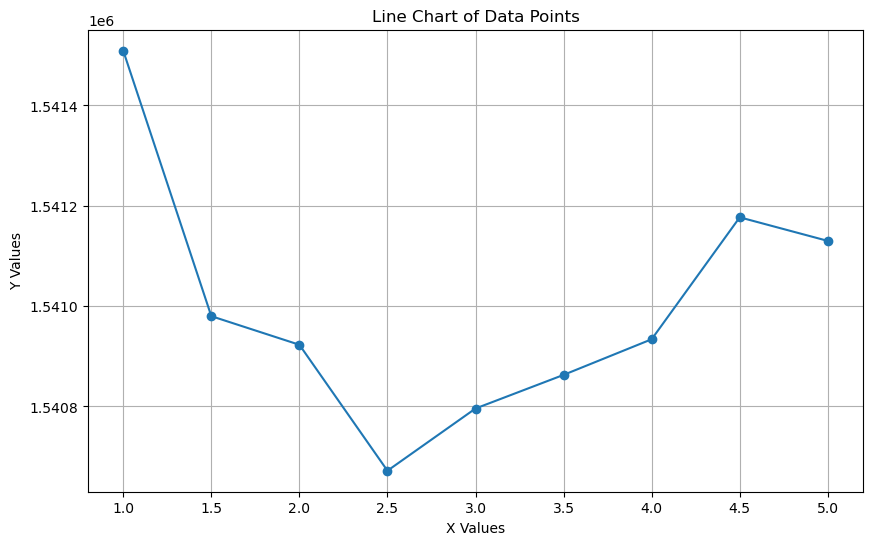

In [13]:
# Data points provided
x_values = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
y_values = [1541509, 1540980, 1540923, 1540672, 1540796, 1540863, 1540934, 1541177, 1541130]

# Create the line chart
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.title('Line Chart of Data Points')
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.grid(True)  # Add grid lines
plt.savefig('line_graph.png')
plt.show()

In [15]:
#Given that beta is relatively small, I will consider a scenario in which beta is 50% larger and 100% larger from its default value
beta_b1 = beta*2.5
beta_b2 = beta*4

#Calculate flows using 'raw' equation

#Recalculate A_i such that flows between other stations are recalibrated correctly
Dj_gamma = cdatasub["jobs"]**gamma
dist_decay_b1 = np.exp(cdatasub['distance']*(-beta_b1))
dist_decay_b2 = np.exp(cdatasub['distance']*(-beta_b2))

#Recalculate alpha_i for scenario a
cdatasub["alpha_i_partial_b1"] = Dj_gamma * dist_decay_b1
cdatasub["alpha_i_partial_b2"] = Dj_gamma * dist_decay_b2

#Sum over all destinations
A_i_b1 = pd.DataFrame(cdatasub.groupby(["station_origin"])["alpha_i_partial_b1"].agg(np.sum))
A_i_b2 = pd.DataFrame(cdatasub.groupby(["station_origin"])["alpha_i_partial_b2"].agg(np.sum))

#Divide over 1
A_i_b1["alpha_i_partial_b1"] = 1/A_i_b1["alpha_i_partial_b1"]
A_i_b2["alpha_i_partial_b2"] = 1/A_i_b2["alpha_i_partial_b2"]

#Rename
A_i_b1.rename(columns={"alpha_i_partial_b1":"alpha_i_sec_b1"}, inplace=True)
A_i_b2.rename(columns={"alpha_i_partial_b2":"alpha_i_sec_b2"}, inplace=True)

#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i_b1, left_on="station_origin", right_index=True, how="left")
cdatasub = cdatasub.merge(A_i_b2, left_on="station_origin", right_index=True, how="left")

#Calculate new flows for scenario b1
cdatasub["flows_scenario_b1"] = np.round(cdatasub["alpha_i_sec_b1"]*cdatasub["population"]*Dj_gamma*dist_decay_b1)

#Calculate new flows for scenario b2
cdatasub["flows_scenario_b2"] = np.round(cdatasub["alpha_i_sec_b2"]*cdatasub["population"]*Dj_gamma*dist_decay_b2)


In [16]:
#Matrix View (Code Taken from Practical 3)
matrix_25 = cdatasub.pivot_table(values ="flows_scenario_b1", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
print(matrix_25)

station_destination  Abbey Road  Acton Central  Acton Town  Aldgate  \
station_origin                                                        
Abbey Road                  NaN            NaN         NaN      NaN   
Acton Central               NaN            NaN         NaN      NaN   
Acton Town                  NaN            NaN         NaN      2.0   
Aldgate                     NaN            NaN         0.0      NaN   
Aldgate East                NaN            NaN         0.0     70.0   
...                         ...            ...         ...      ...   
Woodford                    NaN            NaN         0.0     16.0   
Woodgrange Park             NaN            0.0         NaN      NaN   
Woodside Park               NaN            NaN         0.0      6.0   
Woolwich Arsenal           30.0            NaN         NaN      NaN   
All                       767.0          482.0      3465.0   6868.0   

station_destination  Aldgate East  All Saints  Alperton  Amersham  Anerley  

In [17]:
matrix_40 = cdatasub.pivot_table(values ="flows_scenario_b2", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
print(matrix_40)

station_destination  Abbey Road  Acton Central  Acton Town  Aldgate  \
station_origin                                                        
Abbey Road                  NaN            NaN         NaN      NaN   
Acton Central               NaN            NaN         NaN      NaN   
Acton Town                  NaN            NaN         NaN      0.0   
Aldgate                     NaN            NaN         0.0      NaN   
Aldgate East                NaN            NaN         0.0     94.0   
...                         ...            ...         ...      ...   
Woodford                    NaN            NaN         0.0      2.0   
Woodgrange Park             NaN            0.0         NaN      NaN   
Woodside Park               NaN            NaN         0.0      0.0   
Woolwich Arsenal           16.0            NaN         NaN      NaN   
All                      1354.0          576.0      4658.0   5424.0   

station_destination  Aldgate East  All Saints  Alperton  Amersham  Anerley  

## Analysis of Changes in Commuter Flow
Ideas

Scatterplot of average commuters by distance between station by scenario - could run regression here? Percent difference in commute flows per station pair between the models (could also be scatterplot)

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate flow differences between scenarios
diff_jobs = matrix_jobs - matrix_origin
diff_25 = matrix_25 - matrix_origin
diff_40 = matrix_40 - matrix_origin



# Analyze magnitude and direction of flow changes
magnitude_jobs = np.abs(diff_jobs)
magnitude_25 = np.abs(diff_25)
magnitude_40 = np.abs(diff_40)

# Compare scenarios
total_change_jobs = np.sum(magnitude_jobs)
total_change_25 = np.sum(magnitude_25)
total_change_40 = np.sum(magnitude_40)


# Consider relative impacts
impact_jobs = total_change_jobs / np.sum(matrix_origin)
impact_25 = total_change_25 / np.sum(matrix_origin)
impact_40 = total_change_40 / np.sum(matrix_origin)


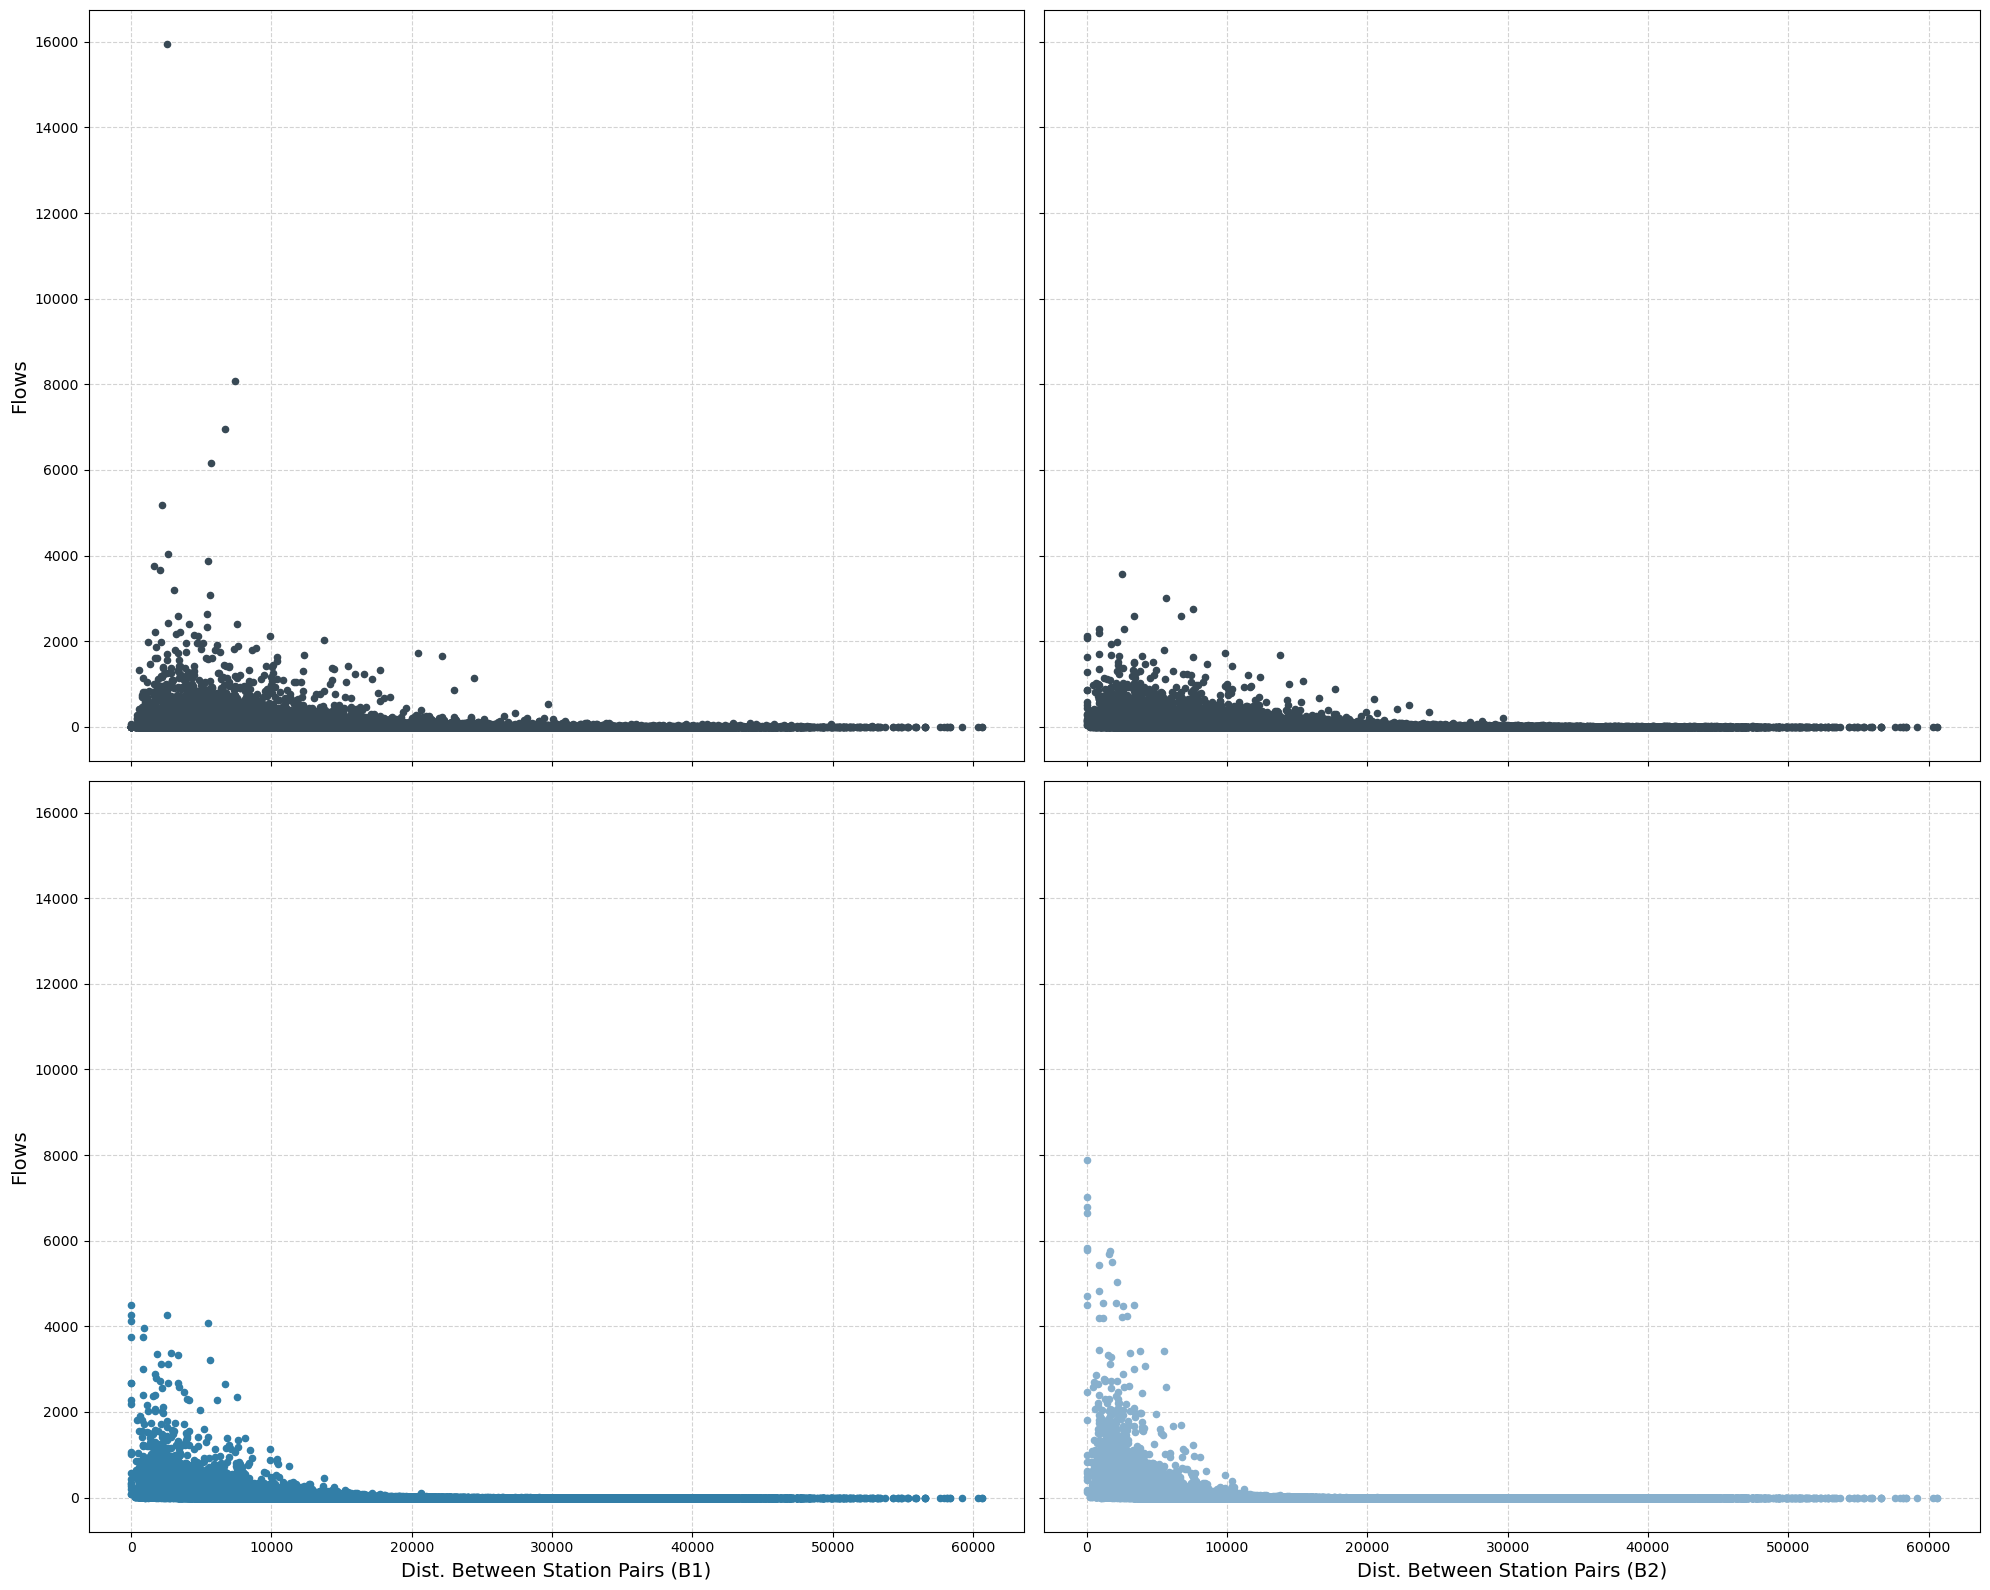

In [89]:
# Scatterplot/regression
# Basic visualization
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(20, 16))

plto = cdatasub.plot(kind='scatter', x='distance', y='flows', ax=axs[0, 0], color='#384955', zorder=2)
plto.set_xlabel('Dist. Between Station Pairs', fontsize=14)
plto.set_ylabel('Flows', fontsize=14)
plto.grid(color='#d3d3d3', linestyle='--', zorder=1)

plta = cdatasub.plot(kind='scatter', x='distance', y='flows_scenario_a', ax=axs[0, 1], color='#384955', zorder=2)
plta.set_xlabel('Dist. Between Station Pairs (A)', fontsize=14)
plta.set_ylabel('Flows', fontsize=14)
plta.grid(color='#d3d3d3', linestyle='--', zorder=1)

pltb1 = cdatasub.plot(kind='scatter', x='distance', y='flows_scenario_b1', ax=axs[1, 0], color='#327EA7', zorder=2)
pltb1.set_xlabel('Dist. Between Station Pairs (B1)', fontsize=14)
pltb1.set_ylabel('Flows', fontsize=14)
pltb1.grid(color='#d3d3d3', linestyle='--', zorder=1)

pltb2 = cdatasub.plot(kind='scatter', x='distance', y='flows_scenario_b2', ax=axs[1, 1], color='#88B0CD', zorder=2)
pltb2.set_xlabel('Dist. Between Station Pairs (B2)', fontsize=14)
pltb2.set_ylabel('Flows', fontsize=14)
pltb2.grid(color='#d3d3d3', linestyle='--', zorder=1)

# Adjust layout and display the plot
plt.tight_layout()

plt.savefig('scatter_graph.png')
plt.show()


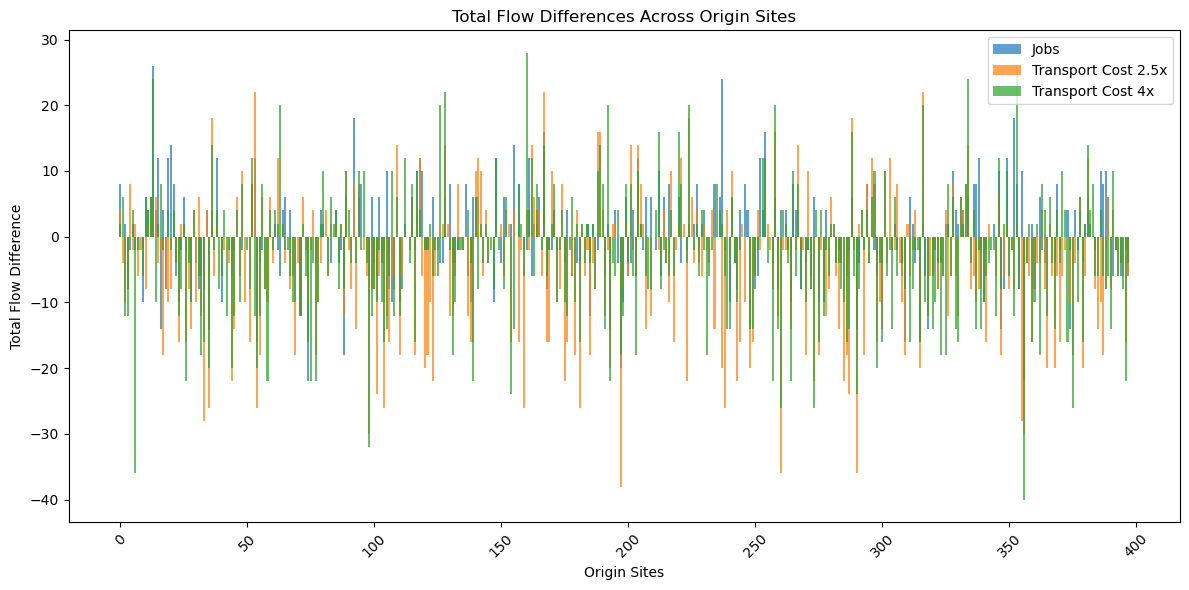

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Aggregate flow differences
agg_diff_jobs = np.sum(diff_jobs, axis=1)
agg_diff_25 = np.sum(diff_25, axis=1)
agg_diff_40 = np.sum(diff_40, axis=1)

# Plot aggregated flow differences using bar charts
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(agg_diff_jobs[:-1])), agg_diff_jobs[:-1], label='Jobs', alpha=0.7)
plt.bar(np.arange(len(agg_diff_25[:-1])), agg_diff_25[:-1], label='Transport Cost 2.5x', alpha=0.7)
plt.bar(np.arange(len(agg_diff_40[:-1])), agg_diff_40[:-1], label='Transport Cost 4x', alpha=0.7)
plt.xlabel('Origin Sites')
plt.ylabel('Total Flow Difference')
plt.title('Total Flow Differences Across Origin Sites')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('differences.png')
plt.show()


In [92]:
matrix_jobs.iloc[-1, -1]

1541507.0

In [93]:
matrix.iloc[-1, -1]

1541130.0

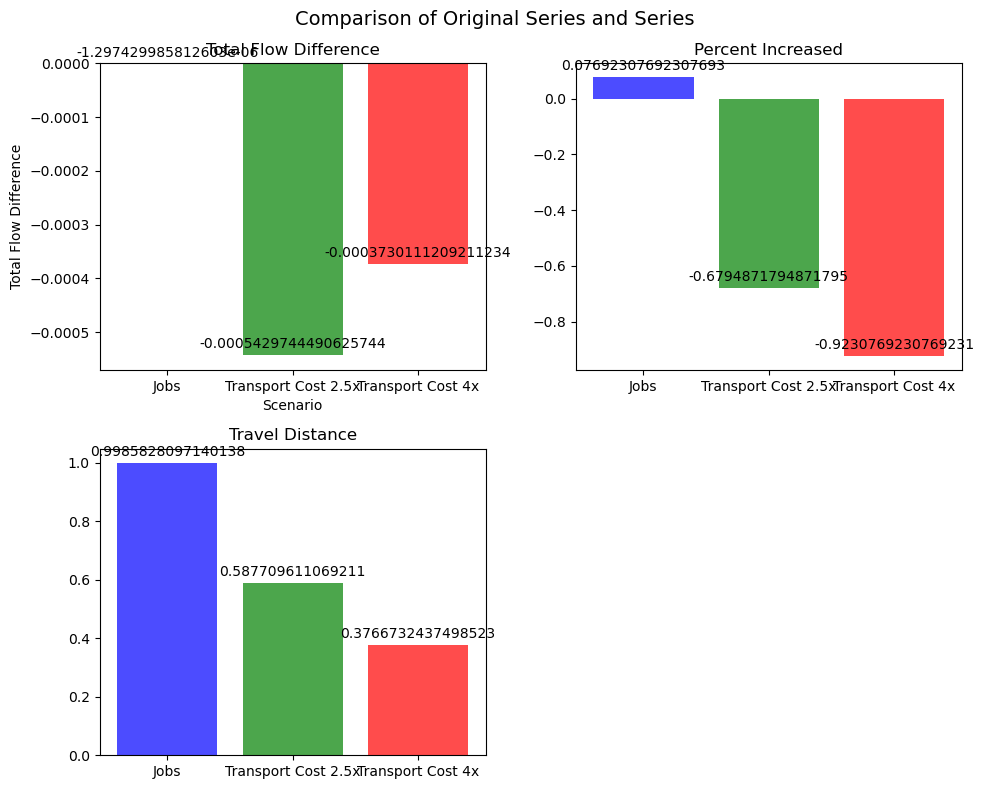

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Total flow differences for each scenario
total_flow_diffs = [(matrix_jobs.iloc[-1, -1] - matrix_origin.iloc[-1, -1])/matrix_origin.iloc[-1, -1], (matrix_25.iloc[-1, -1] - matrix_origin.iloc[-1, -1])/matrix_origin.iloc[-1, -1], (matrix_40.iloc[-1, -1] - matrix_origin.iloc[-1, -1])/matrix_origin.iloc[-1, -1]]

percent_increased_a = ((cdatasub['flows_scenario_a'] - cdatasub['doubsimfitted'])/cdatasub['doubsimfitted']).fillna(0)[0].mean()
percent_increased_b1 = ((cdatasub['flows_scenario_b1'] - cdatasub['doubsimfitted'])/cdatasub['doubsimfitted']).fillna(0)[0].mean()
percent_increased_b2 = ((cdatasub['flows_scenario_b2'] - cdatasub['doubsimfitted'])/cdatasub['doubsimfitted']).fillna(0)[0].mean()
# Percentage of pairs with increased flow for each scenario
percent_increased = [percent_increased_a, percent_increased_b1, percent_increased_b2]

distance_ori = sum(cdatasub['distance']*cdatasub['flows']) / sum(cdatasub['flows'])
distance_a = (sum(cdatasub['distance']*cdatasub['flows_scenario_a']) / sum(cdatasub['flows_scenario_a']))/distance_ori
distance_b1 = (sum(cdatasub['distance']*cdatasub['flows_scenario_b1']) / sum(cdatasub['flows_scenario_b1']))/distance_ori
distance_b2 = (sum(cdatasub['distance']*cdatasub['flows_scenario_b2']) / sum(cdatasub['flows_scenario_b2']))/distance_ori
distance = [distance_a, distance_b1, distance_b2]


# Scenario labels
scenarios = ['Jobs', 'Transport Cost 2.5x', 'Transport Cost 4x']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot original Series in the first subplot
bar_diff = axs[0, 0].bar(scenarios, total_flow_diffs, color=['blue', 'green', 'red'], alpha=0.7, label='Total Flow Difference')
axs[0, 0].set_title('Total Flow Difference')
for bar in bar_diff:
    height = bar.get_height()
    axs[0, 0].annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
axs[0, 0].set_xlabel('Scenario')
axs[0, 0].set_ylabel('Total Flow Difference')


# Plot Series with NaN values replaced by 0 in the second subplot
bar_percentage = axs[0, 1].bar(scenarios,percent_increased, color=['blue', 'green', 'red'], alpha=0.7, label='Percent Increased Flow')
axs[0, 1].set_title('Percent Increased')
for bar in bar_percentage:
    height = bar.get_height()
    axs[0, 1].annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


bar_distance = axs[1, 0].bar(scenarios,distance, color=['blue', 'green', 'red'], alpha=0.7, label='Travel Distance')
axs[1, 0].set_title('Travel Distance')
for bar in bar_distance:
    height = bar.get_height()
    axs[1, 0].annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# Set common labels
fig.suptitle('Comparison of Original Series and Series', fontsize=14)
plt.xlabel('Index')
plt.ylabel('Values')

# Hide the fourth subplot as it's not used in the 2x2 layout
axs[1, 1].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('bar.png')
plt.show()

